In [2]:
import camelot, fitz, ghostscript, matplotlib.pyplot as plt, os, pandas as pd, re

c:\Users\dbreau\Documents\Repositories\data_ing_cert\venv\Lib\site-packages\pypdf\_crypt_providers\_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4


In [6]:
path = 'data'
opened_doc = fitz.open('data/BOURESSE_E01_Check_ICPE_Electrical_2023-06-28_60680836.pdf')
print(opened_doc.metadata)

{'format': 'PDF 1.3', 'title': '', 'author': 'BATCHUSER ', 'subject': '', 'keywords': '', 'creator': 'Form YPM_COMMON_S_REP EN', 'producer': 'SAP NetWeaver 740 ', 'creationDate': 'D:20230704123815', 'modDate': '', 'trapped': '', 'encryption': None}


In [25]:
class PDF:
    def __init__(self, path):
        self.path = path
        
        opened_doc = fitz.open(self.path)
        self.page_numbers = len(opened_doc)
        
        self.header_informations = self._get_header_informations(opened_doc)
        self.sif_page = self._get_sif_page(opened_doc)
        
        opened_doc.close()
    
    def _get_header_informations(self, opened_doc):
        text = opened_doc[0].get_text()
       
        turbine_number = re.search(r'Turbine No\./Id:\s*(\d+)', text).group(1) if re.search(r'Turbine No\./Id:\s*(\d+)', text) else None
        service_order = re.search(r'Service Order:\s*(\d+)', text).group(1) if re.search(r'Service Order:\s*(\d+)', text) else None
        pad_no = (match.group(1).strip() if (match := re.search(r'PAD No\.\s*([^\n]+)', text)) else None)
        turbine_type = re.search(r'Turbine Type:\s*([\w\d]+)', text).group(1) if re.search(r'Turbine Type:\s*([\w\d]+)', text) else None
        start_date = re.search(r'Start Date:\s*([\d\.]+)', text).group(1) if re.search(r'Start Date:\s*([\d\.]+)', text) else None
        end_date = (match.group(1) if (match := re.search(r'End Date:\s*([\d\.]+)', text)) else None)
        date_and_time_of_receipt = (match.group(1).strip() if (match := re.search(r'Date & Time of Receipt\s*([\d\.\s:]+)', text)) else None)
        reason_for_call_out = (match.group(1) if (match := re.search(r'Reason for Call Out:\s*([^\n]+)', text)) else None)
                
        customer_address = ([line.strip() for line in match.group(1).split('\n') if line.strip()] 
                       if (match := re.search(r"Customer's Address:\s*(.*?)Site's Address:", text, re.DOTALL)) 
                       else None)

        return {
            'turbine_number': turbine_number,
            'service_order': service_order,
            'pad_no': pad_no,
            'turbine_type': turbine_type,
            'start_date': start_date,
            'customer_address': customer_address,
            'date_and_time_of_receipt': date_and_time_of_receipt,
            'reason_for_call_out': reason_for_call_out
        }
    
    def _get_sif_page(self, opened_doc):
        for page_num in range(self.page_numbers):
            if "Service Inspection Form" in opened_doc[page_num].get_text():
                return page_num
        raise ValueError("'Service Inspection Form' non trouvé dans le document")
    
    def get_page_table(self, page_number):
        tables = camelot.read_pdf(
            self.path,
            pages=str(page_number),
            flavor='stream',
            edge_tol=500,
            row_tol=10,
            columns=['65,330,350'] 
        )
        
        if len(tables) > 0:
            return tables[0].df
        else:
            raise ValueError(f"Aucune table trouvée à la page {page_number}")
    
    def get_full_table(self):
        all_tables = []
        
        for page_num in range(self.sif_page, self.page_numbers):
            try:
                table = self.get_page_table(page_num + 1)
                all_tables.append(table)
            except ValueError:
                continue
        
        if not all_tables:
            raise ValueError("Aucune table trouvée dans le document")
        
        return pd.concat(all_tables, ignore_index=True)
    
    def save_csv(self):
        self.get_full_table().to_csv("test.csv", index=False)

In [26]:
pdf_test = PDF(path='data/BOURESSE_E01_Check_ICPE_Electrical_2023-06-28_60680836.pdf')
pdf_test.get_full_table()

,0,1,2,3
0,,,215372,60680836
1,Service Inspection Form,,,
2,0010,"Check ICPE Electrical V100 1,8MW MK7",,
3,0,eSIF,,
4,0.01,0. DMS: 0093-0083 V03,,
...,...,...,...,...
58,,,Turbine No./Id:\n215372,Service order\n60680836
59,4.07,"Si installés, contrôle du bon fonctionnement d...",,
60,4.08,Remarks: (as a comment),,
61,,,,Not Applicable


In [27]:
pdf_test.save_csv()

In [14]:
def get_full_table(self):
    # Liste pour stocker tous les DataFrames
    all_tables = []
    
    print(f"SIF page: {self.sif_page}")  # Debug
    print(f"Total pages: {self.page_numbers}")  # Debug
    
    # Extraire les tables de chaque page, de sif_page jusqu'à la fin
    for page_num in range(self.sif_page, self.page_numbers):
        try:
            print(f"Trying page {page_num + 1}")  # Debug
            # +1 car Camelot commence à 1
            table = self.get_page_table(page_num + 1)
            print(f"Found table with shape {table.shape}")  # Debug
            all_tables.append(table)
        except ValueError as e:
            print(f"Error on page {page_num + 1}: {str(e)}")  # Debug
            continue
    
    if not all_tables:
        raise ValueError("Aucune table trouvée dans le document")
    
    final_table = pd.concat(all_tables, ignore_index=True)
    print(f"Final table shape: {final_table.shape}")  # Debug
    return final_table

In [11]:
doc = fitz.open('data/BOURESSE_E01_Check_ICPE_Electrical_2023-06-28_60680836.pdf')

page_1 = doc[0].get_text()

import re

def extraire_informations(text):
    # Créer un dictionnaire pour stocker les informations
    infos = {}
    
    # Définir les patterns pour extraire les informations
    patterns = {
        'turbine_number': r'Turbine No\./Id:\s*(\d+)',
        'service_order': r'Service Order:\s*(\d+)',
        'pad_no': r'PAD No\.\s*([\w\s]+)',
        'turbine_type': r'Turbine Type:\s*([\w\d]+)',
        'start_date': r'Start Date:\s*([\d\.]+)',
        'customer_address': r"Customer's Address:\s*(.*?)Site's Address:",
    }
    
    # Extraire chaque information
    for key, pattern in patterns.items():
        match = re.search(pattern, text, re.DOTALL)  # re.DOTALL pour gérer les sauts de ligne
        if match:
            # Nettoyer le texte extrait (enlever les espaces superflus et sauts de ligne)
            value = match.group(1).strip()
            # Pour l'adresse, séparer les lignes
            if key == 'customer_address':
                value = [line.strip() for line in value.split('\n') if line.strip()]
            infos[key] = value
    
    return infos

# Utiliser la fonction
text = doc[0].get_text()
informations = extraire_informations(text)

# Afficher les résultats
for key, value in informations.items():
    print(f"{key}: {value}")
    
turbine_number = informations['turbine_number']
print(turbine_number)

turbine_number: 215372
service_order: 60680836
pad_no: BOURESSE E01
Turbine Type
turbine_type: V100
start_date: 28.06.2023
customer_address: ['BOURESSE ENERGIES', '29 RUE DES ROSATI', 'F-62000 ARRAS']
215372


In [23]:
# Lire le contenu du PDF
text = extract_text('data/BOURESSE_E01_Check_ICPE_Electrical_2023-06-28_60680836.pdf')

# Afficher le texte extrait
print(text)

Turbine No./Id:
215372

Service Order:
60680836

PAD No.
BOURESSE E01

Turbine Type:
V100

Start Date:
28.06.2023

End Date:
28.06.2023

Customer's
Ref./P.O.No.:
Vestas Ref.:
IP1020221127

Date & Time of Receipt
27.11.2022 19:30:26

Service Report

Customer's Address:
BOURESSE ENERGIES

29 RUE DES ROSATI

F-62000 ARRAS

Site's Address:
F-

Reason for Call Out: Check ICPE Electrical
Check ICPE Electrical

___________________________________________________________________________________________________________________
Work Performed

The ICPE Check was done according to the SIF.Do it 28/06/2023Pause
8:42Run 15:08

___________________________________________________________________________________________________________________
Specification of Item Consumption
Item

Serial Number

Description

Quantity

UoM

___________________________________________________________________________________________________________________

______________________________________________________________

<Figure size 640x480 with 0 Axes>

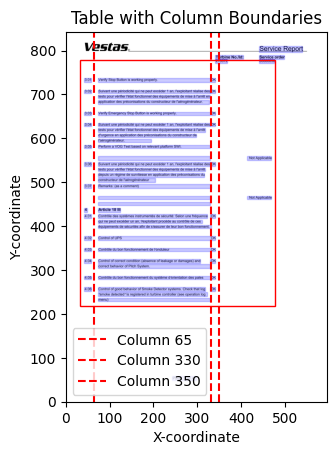

,0,1,2,3
0,,,215372,60680836
1,3.01,Verify Stop Button is working properly. ...,,
2,3.02,Suivant une périodicité qui ne peut excéder 1 ...,OK,
3,,tests pour vérifier l'état fonctionnel des équ...,,
4,,application des préconisations du constructeur...,,
5,3.03,Verify Emergency Stop Button is working proper...,,
6,3.04,Suivant une périodicité qui ne peut excéder 1 ...,OK,
7,,tests pour vérifier l'état fonctionnel des équ...,,
8,,d'urgence en application des préconisations du...,,
9,,l'aérogénérateur.,,


In [11]:
# Extract table with specified columns
tables = camelot.read_pdf('data\BOURESSE_E01_Check_ICPE_Electrical_2023-06-28_60680836.pdf', flavor='stream', pages='3', edge_tol=500, row_tol=10, columns=['65, 330, 350'])

# Overlay column boundaries on the same plot
plt.figure()
camelot.plot(tables[0], kind='contour')
for col in [65, 330, 350]:
    plt.axvline(x=col, color='r', linestyle='--', label=f'Column {col}')
plt.title('Table with Column Boundaries')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.show()

df = tables[0].df
df.to_csv('test.csv')
df

C:\Users\dbreau\AppData\Local\Temp\ipykernel_1788\3416746233.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  camelot.plot(tables[0], kind='contour').show()


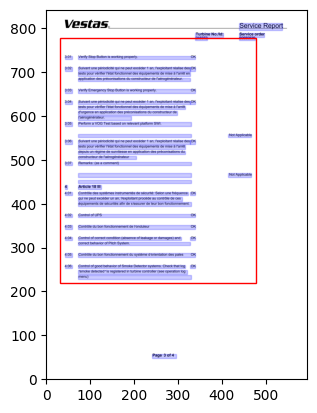

In [20]:
tables = camelot.read_pdf('data\BOURESSE_E01_Check_ICPE_Electrical_2023-06-28_60680836.pdf', flavor='stream', pages='3', edge_tol=500, row_tol=10, columns=['10, 20, 100, 110'])

camelot.plot(tables[0], kind='contour').show()